### PRACTICA 3 VC 😊

##### Instalamos los paquetes necesarios

In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
import seaborn as sns


Carga imagen y convierte a RGB

**TAREA 1**: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€).



Empezamos identificando de forma interactiva haciendo click la moneda seleccionada

In [2]:
# Diametro de las monedas
monedas_info = {
    "1 céntimo": {"diámetro": 16.26},
    "2 céntimos": {"diámetro": 18.75},
    "5 céntimos": {"diámetro": 20.25},
    "10 céntimos": {"diámetro": 19.75},
    "20 céntimos": {"diámetro": 22.55},
    "50 céntimos": {"diámetro": 22.85},
    "1 euro": {"diámetro": 22.25},
    "2 euros": {"diámetro": 25.75}
}


img = cv2.imread('Monedas.jpg') 
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Conversión a gris
pimg = cv2.medianBlur(gris, 7)

#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,   
        cv2.HOUGH_GRADIENT,  # Tipo de detección
        1, # factor de escalado
        100,  # distancia mínima
        param1=100, # Gradiente
        param2=50, # Umbral acumulador
        minRadius=50,  # Radio mínimo
        maxRadius=150,  # Radio máximo
    )


selected_circle = None

# Manejamos el evento del mouse
def on_mouse(event, x, y, flags, params):
    global selected_circle
    if event == cv2.EVENT_LBUTTONDOWN:
        min_distance = float('inf')
        for det in circ[0]:
            x_coor, y_coor, det_radio = det
            distance = np.sqrt((x - x_coor) ** 2 + (y - y_coor) ** 2)
            if distance < min_distance:
                min_distance = distance
                selected_circle = det
        if selected_circle is not None:
            cv2.destroyAllWindows()

def calcular_diametro_mm(radio_pixels, escala_mm_por_pixel):
    diametro_pixels = radio_pixels * 2  # diámetro en píxeles
    return diametro_pixels * escala_mm_por_pixel


def identificar_moneda(diametro_mm):
    moneda_mas_cercana = None
    diferencia_minima = float('inf') 
    for nombre, info in monedas_info.items():
        diferencia = abs(diametro_mm - info["diámetro"])
        if diferencia < diferencia_minima:
            diferencia_minima = diferencia
            moneda_mas_cercana = nombre
    return moneda_mas_cercana


Aplicamos los circulos a partir del diametro de las monedas a partir de una tolerancia aproximada

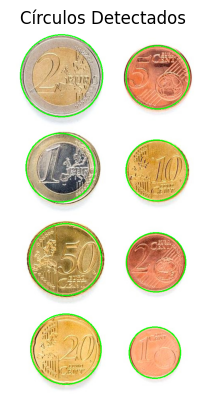

Hay 8 monedas en la imagen
Diámetro seleccionado en milímetros: 22.27
Diámetro seleccionado en pixeles: 175
La moneda identificada es: 1 euro


In [3]:
# Dibujamos los circulos detectados
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for det in circ[0]:
    x_coor, y_coor, det_radio = det
    cv2.circle(img_rgb, (int(x_coor), int(y_coor)), int(det_radio), (0, 255, 0), 2)

# Mostar la imagen con los círculos detectados
plt.imshow(img_rgb)
plt.axis("off")
plt.title('Círculos Detectados')
plt.show()
print("Hay", len(circ[0]), "monedas en la imagen")
cv2.namedWindow('Imagen con Círculos', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Imagen con Círculos', 400, 650)
cv2.setMouseCallback('Imagen con Círculos', on_mouse)
cv2.imshow('Imagen con Círculos', img_rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()


escala_mm_por_pixel = 50 / 100  # mm/píxel

# Comprobamos si se ha seleccionado un círculo
if selected_circle is not None:
    radio_seleccionado = selected_circle[2]  # radio en píxeles
    diametro_seleccionado_mm = calcular_diametro_mm(radio_seleccionado, escala_mm_por_pixel)
    print("Diámetro seleccionado en milímetros:", round(diametro_seleccionado_mm/3.92, 2))
    print("Diámetro seleccionado en pixeles:", round(radio_seleccionado*2))

    moneda_identificada = identificar_moneda(diametro_seleccionado_mm/4)
    
    if moneda_identificada:
        print("La moneda identificada es:", moneda_identificada)
    else:
        print("No se pudo identificar la moneda.")
else:
    print("No se ha seleccionado ninguna moneda.")


La solución funciona bien para este caso en particular, pero es importante tener en cuenta que si cambiamos de imagen, especialmente con más ruido o variaciones en las condiciones de captura, podemos enfrentarnos a problemas. Al final, se trata de una aproximación basada en el diámetro de las monedas, y al depender de un umbral, existe un cierto margen de error que puede aumentar o disminuir según la calidad de la imagen. Este enfoque puede fallar en algunas situaciones debido a las limitaciones inherentes de medir únicamente el diámetro.

Ahora intentaremos mostrar la cantidad de dinero presente en la imagen

Nº de monedas: 8
Valor total: 3.88 €


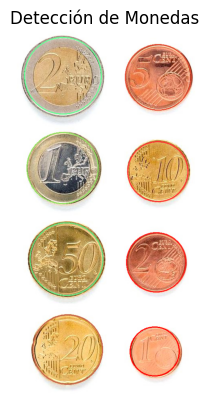

In [4]:
def draw_circle(img, img_cont, color, x, y, r):
    cv2.circle(img, (int(x), int(y)), int(r), color, 2)  # Dibuja el contorno del círculo
    cv2.circle(img_cont, (int(x), int(y)), int(r), color, -1)  

def draw_contornos(contornos, img, img_cont, color):
    cv2.drawContours(img, contornos, -1, color, 5)  # Dibuja el contorno en la imagen 
    cv2.drawContours(img_cont, contornos, -1, color, -1)

# Determinamos el valor de la moneda y dibujar el círculo
def draw_contour(x, y, r, img, contour, all_coins, coin_type):
    coin_values = [
        {"name": "0.01", "range": (0, 65), "color": (255, 0, 0), "value": 0.01},
        {"name": "0.02", "range": (65, 76), "color": (255, 25, 25), "value": 0.02},
        {"name": "0.10", "range": (76, 80), "color": (255, 50, 50), "value": 0.10},
        {"name": "0.05", "range": (80, 85), "color": (225, 75, 50), "value": 0.05},
        {"name": "0.20", "range": (85, 90), "color": (200, 100, 75), "value": 0.20},
        {"name": "1", "range": (90, 92), "color": (150, 225, 100), "value": 1.0},
        {"name": "0.50", "range": (92, 95), "color": (100, 225, 125), "value": 0.50},
        {"name": "2", "range": (95, float('inf')), "color": (100, 255, 150), "value": 2.0}
    ]

    for coin in coin_values:
        if (coin_type == coin["name"] or all_coins) and coin["range"][0] < r < coin["range"][1]:
            draw_circle(img, contour, coin["color"], x, y, r)
            return coin["value"]
    
    return 0.0

def identificar_moneda(dir_img, moneda, todas):
    cont = 0
    total_valor = 0.0
    
    img = cv2.imread(dir_img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Conversión a escala de grises y suavizado
    gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pimg = cv2.GaussianBlur(gris, (5, 5), 1)
    
    # Detección de círculos
    circ = cv2.HoughCircles(
        pimg, 
        cv2.HOUGH_GRADIENT, 
        dp=1, 
        minDist=80, 
        param1=70, 
        param2=70, 
        minRadius=0, 
        maxRadius=100
    )

    img_cont = np.zeros(img_rgb.shape) # Imagen de contornos vacía

    # Dibujamos de los círculos detectados
    if circ is not None:
        for det in circ[0]:
            cont += 1
            x_coor, y_coor, det_radio = det
            total_valor += draw_contour(x_coor, y_coor, det_radio, img_rgb, img_cont, todas, moneda)

    print(f"Nº de monedas: {cont}")
    print(f"Valor total: {total_valor} €")
    plt.axis("off")
    plt.imshow(img_rgb)
    plt.title('Detección de Monedas')
    plt.show()

# Ejemplo de uso
identificar_moneda('Monedas.jpg', "0.01", True)


Para este caso en particular funciona muy bien pero si probamos casos mas complejos como monedas apiladas, vemos que los resultados no son los esperados.

Nº de monedas: 7
Valor total: 7.4 €


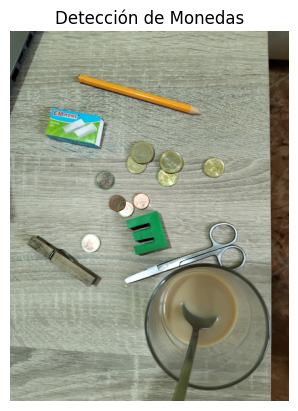

Nº de monedas: 39
Valor total: 8.809999999999993 €


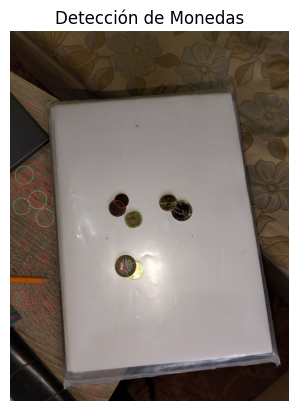

In [5]:
identificar_moneda('moneda_test_segundo.jpg', "0.01", True)
identificar_moneda('moneda_test_primero.jpg', "0.01", True)


Estamos viendo que con monedas solapadas tenmos problemas para identificarlo, y no solo eso sino que poner las monedas en diferentes situaciones hace que se confunda mucho el modelo planteado, por lo que vamos a plantear uno mejorado.

Imagen 'moneda_test_primero.jpg' cargada exitosamente.
Preprocesamiento de la imagen completado.
Se detectaron 6 círculos en la imagen.
Círculos dibujados en las imágenes.


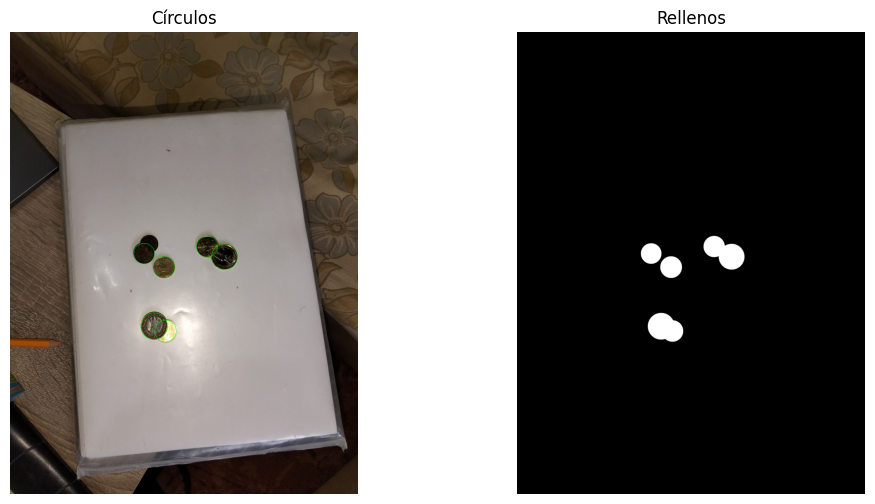

Haz clic en la imagen para seleccionar un círculo.
Círculo seleccionado:
  Centro (píxeles): (1740, 1894)
  Radio (píxeles): 94
  Diámetro (píxeles): 188
Radio seleccionado: 94
1 euro
0.50 céntimos
0.20 céntimos
1 euro
Hay 2.7 € en la imagen.

Imagen 'moneda_test_segundo.jpg' cargada exitosamente.
Preprocesamiento de la imagen completado.
Se detectaron 12 círculos en la imagen.
Círculos dibujados en las imágenes.


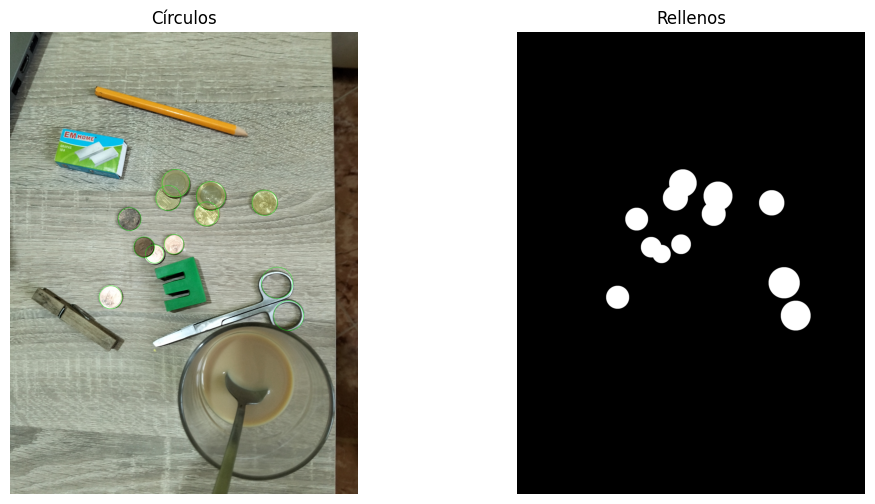

Haz clic en la imagen para seleccionar un círculo.
Círculo seleccionado:
  Centro (píxeles): (1736, 1606)
  Radio (píxeles): 106
  Diámetro (píxeles): 212
Radio seleccionado: 106
0.20 céntimos
0.20 céntimos
1 euro
0.10 céntimos
0.02 céntimos
0.50 céntimos
0.50 céntimos
Hay 2.52 € en la imagen.


In [6]:
class CoinDetector:
    def __init__(self, image_path):
        self.image_path = image_path
        self.selected_circle = None
        self.circles = None
        self.img = None
        self.img_rgb = None
        self.img_cont = None

    def load_image(self):
        """Carga la imagen y prepara las versiones RGB y de contornos."""
        self.img = cv2.imread(self.image_path)
        if self.img is None:
            raise FileNotFoundError(f"No se pudo cargar la imagen en la ruta: {self.image_path}")
        self.img_rgb = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        self.img_cont = np.zeros_like(self.img_rgb)
        print(f"Imagen '{self.image_path}' cargada exitosamente.")

    def preprocess_image(self):
        """Convierte la imagen a escala de grises y aplica un desenfoque para reducir el ruido."""
        gris = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.preprocessed_img = cv2.medianBlur(gris, 7)
        print("Preprocesamiento de la imagen completado.")

    def detect_circles(self, dp=1, min_dist=100, param1=100, param2=50, min_radius=50, max_radius=150):
        """Detecta círculos en la imagen utilizando la Transformada de Hough."""
        self.circles = cv2.HoughCircles(
            self.preprocessed_img,
            cv2.HOUGH_GRADIENT,
            dp=dp,
            minDist=min_dist,
            param1=param1,
            param2=param2,
            minRadius=min_radius,
            maxRadius=max_radius
        )
        if self.circles is not None:
            self.circles = np.uint16(np.around(self.circles))
            print(f"Se detectaron {len(self.circles[0])} círculos en la imagen.")
        else:
            print("No se detectaron círculos en la imagen.")

    def draw_circles(self, color_outline=(0, 255, 0), color_fill=(255, 255, 255)):
        """Dibuja los círculos detectados en las imágenes RGB y de contornos."""
        if self.circles is not None:
            for det in self.circles[0]:
                x, y, r = det
                cv2.circle(self.img_rgb, (x, y), r, color_outline, 2)
                cv2.circle(self.img_cont, (x, y), r, color_fill, -1)
            print("Círculos dibujados en las imágenes.")

    def display_images(self, titles=['Círculos', 'Rellenos']):
        """Muestra las imágenes de círculos y contornos."""
        plt.figure(figsize=(12, 6))
        for i, (img, title) in enumerate(zip([self.img_rgb, self.img_cont], titles), 1):
            plt.subplot(1, 2, i)
            plt.axis("off")
            plt.imshow(img)
            plt.title(title)
        plt.show()

    def on_mouse_click(self, event, x, y, flags, param):
        """Maneja los eventos de clic del ratón para seleccionar el círculo más cercano."""
        if event == cv2.EVENT_LBUTTONDOWN and self.circles is not None:
            min_distance = float('inf')
            closest_circle = None
            for det in self.circles[0]:
                x_coor, y_coor, r = det
                # Convertir a float para evitar overflow
                distance = np.sqrt((float(x) - float(x_coor)) ** 2 + (float(y) - float(y_coor)) ** 2)
                if distance < min_distance:
                    min_distance = distance
                    closest_circle = det
            if closest_circle is not None:
                self.selected_circle = closest_circle
                x_sel, y_sel, r_sel = closest_circle
                diameter = 2 * r_sel
                print(f"Círculo seleccionado:")
                print(f"  Centro (píxeles): ({x_sel}, {y_sel})")
                print(f"  Radio (píxeles): {r_sel}")
                print(f"  Diámetro (píxeles): {diameter}")
                
                # Resaltar el círculo
                cv2.circle(self.img_rgb, (x_sel, y_sel), r_sel, (255, 0, 0), 3)
                
                cv2.putText(
                    self.img_rgb,
                    f"Centro: ({x_sel}, {y_sel})",
                    (x_sel - r_sel, y_sel - r_sel - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (255, 0, 0),
                    1,
                    cv2.LINE_AA
                )
                cv2.putText(
                    self.img_rgb,
                    f"Diametro: {diameter}",
                    (x_sel - r_sel, y_sel - r_sel - 30),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (255, 0, 0),
                    1,
                    cv2.LINE_AA
                )
                
                # Actualizar la imagen mostrada con el círculo resaltado
                cv2.imshow('Imagen con Círculos', cv2.cvtColor(self.img_rgb, cv2.COLOR_RGB2BGR))
                
                cv2.destroyAllWindows()

    def select_circle_interactively(self):
        """Permite al usuario seleccionar un círculo haciendo clic en la imagen."""
        if self.circles is None:
            print("No hay círculos para seleccionar.")
            return
        cv2.namedWindow('Imagen con Círculos', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('Imagen con Círculos', 600, 600)
        cv2.setMouseCallback('Imagen con Círculos', self.on_mouse_click)
        cv2.imshow('Imagen con Círculos', cv2.cvtColor(self.img_rgb, cv2.COLOR_RGB2BGR))
        print("Haz clic en la imagen para seleccionar un círculo.")
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    def identify_coin(self, moneda=None, todas=True):
        """Identifica y suma el valor de las monedas detectadas."""
        if self.circles is None:
            print("No hay círculos detectados para identificar.")
            return

        suma = 0.0
        tolerancia = 2.25  # Tolerancia para la identificación de monedas

        if self.selected_circle is None:
            print("No se ha seleccionado ningún círculo.")
            return

        radio_seleccionado = self.selected_circle[2]
        print(f"Radio seleccionado: {radio_seleccionado}")

        coin_values = [
            {"name": "0.01", "factor": 8.13},
            {"name": "0.02", "factor": 9.375},
            {"name": "0.05", "factor": 10.625},
            {"name": "0.10", "factor": 9.875},
            {"name": "0.20", "factor": 11.125},
            {"name": "0.50", "factor": 12.125},
            {"name": "1", "factor": 11.625},
            {"name": "2", "factor": 12.875},
        ]

        for det in self.circles[0]:
            _, _, det_radio = det
            for coin in coin_values:
                expected_radius = (coin["factor"] * radio_seleccionado) / 11.625
                if abs(det_radio - expected_radius) <= tolerancia:
                    value = float(coin["name"])
                    if (moneda == coin["name"] or todas):
                        suma += value
                        print(f"{coin['name']} céntimos" if value < 1 else f"{int(value)} euro{'s' if value > 1 else ''}")
                    break  

        print(f"Hay {round(suma, 2)} € en la imagen.")

    def run(self, moneda=None, todas=True):
        """Ejecuta todo el flujo de detección e identificación de monedas."""
        self.load_image()
        self.preprocess_image()
        self.detect_circles()
        self.draw_circles()
        self.display_images()
        self.select_circle_interactively()
        self.identify_coin(moneda=moneda, todas=todas)

if __name__ == "__main__":
    detector = CoinDetector('moneda_test_primero.jpg')
    detector.run(moneda="0.10", todas=True)
    print()
    detector = CoinDetector('moneda_test_segundo.jpg')
    detector.run(moneda="0.2", todas=True)



Hemos logrado optimizar el caso de monedas solapadas, aun asi seguimos teniendo un error de calculo, pero ahora funciona mucho mejor que el anterior.

TAREA 2: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Procesada imagen de prueba uno.JPG con 80 partículas.
Procesada imagen de prueba dos.JPG con 54 partículas.
Procesada imagen de prueba tres.JPG con 54 partículas.
Accuracy: 0.59
Precision: 0.62
Recall: 0.59
F1 Score: 0.58


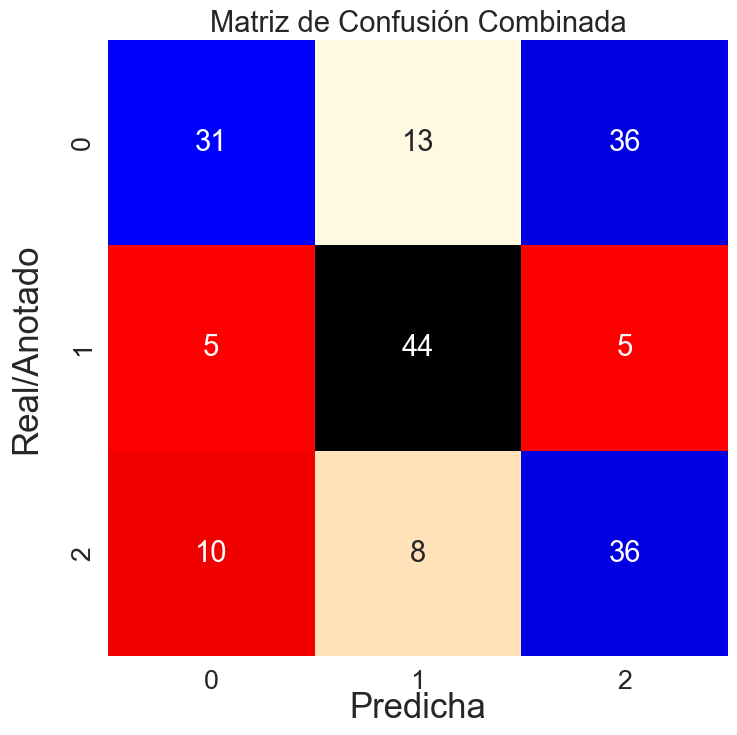

------------------------------------------


In [7]:
def preprocess_and_segment(img):
    # Aplicar un filtro Gaussian Blur
    img_blur = cv2.GaussianBlur(img, (5,5), 0)

    # Aplicar umbralización adaptativa usando Otsu
    _, thresh = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Extraer los contornos
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrar contornos por área para eliminar ruido
    contours = [c for c in contours if cv2.contourArea(c) > 100]  # Ajusta este valor según tus datos

    return contours

def extract_features(contour, img_color):
    features = {}
    
    # Calcular características geométricas clave
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    compactness = (perimeter ** 2) / area if area > 0 else 0

    # Usar boundingRect para calcular el aspect ratio
    _, __, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h if h > 0 else 0

    # Calcular el color medio de la partícula usando el contorno
    mask = np.zeros(img_color.shape[:2], dtype=np.uint8)  # Crear una máscara en blanco
    cv2.drawContours(mask, [contour], -1, 255, -1)  # Dibujar el contorno en la máscara
    mean_color = cv2.mean(img_color, mask=mask)  # Obtener el color medio (BGR)
    
    isBlack = 1 if ((mean_color[0] + mean_color[1] + mean_color[2]) // 3) <= 30 else 0 
    # Guardar las características clave, incluyendo el color medio
    features['area'] = area
    features['perimeter'] = perimeter
    features['compactness'] = compactness
    features['aspect_ratio'] = aspect_ratio
    features['mean_color_B'] = isBlack

    # Retornar todas las características como un array plano
    return list(features.values())

# Función para clasificar partículas y evaluar el resultado
def classify_and_evaluate(X_train, y_train, X_test, y_test):
    # Usar SimpleImputer para manejar valores NaN
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Crear y entrenar el modelo SVM
    model = SVC()
    model.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = model.predict(X_test)

    # Evaluar el rendimiento del modelo usando las métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1score = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1score:.2f}")

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.set(font_scale = 1.75)  # Tamaños tipografía

    ax = sns.heatmap(
            conf_matrix, # matriz de confusión como array 2D
            annot=True,   # Mostrar números en las celdas
            fmt='d',      # Formato entero
            cbar=False,   # Sin barra de colores
            cmap='flag',  # Mapa de colores
        )

    # Etiquetas de la matriz de confusión
    label_font = {'size':'25'}
    ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
    ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)
    
    plt.title("Matriz de Confusión Combinada")
    plt.show()
    
    print("------------------------------------------")

# Zona de entrenamiento
image_paths_train = ["FRA.png", "PEL.png", "TAR.png"]
labels_train = [1, 2, 3]
X_train = []
y_train = []

for img_path, label in zip(image_paths_train, labels_train):
    # Leer la imagen en escala de grises
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error al leer la imagen de entrenamiento: {img_path}")
        continue
    contours = preprocess_and_segment(img)
    for contour in contours:
        features = extract_features(contour, img)
        if not any(np.isnan(features)) and not any(np.isinf(features)):
            X_train.append(features)
            y_train.append(label)

# Zona de prueba
image_paths_test = ["uno.JPG", "dos.JPG", "tres.JPG"]
y_test = [[1] * 80, [2] * 54, [3] * 54]  # Cada sublista corresponde a una imagen de prueba
X_test_combined = []
y_test_combined = []

contador_total = 0  # Contador opcional para seguimiento

for index, img_path in enumerate(image_paths_test):
    # Leer la imagen en escala de grises
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error al leer la imagen de prueba: {img_path}")
        continue
    
    # Obtener el tamaño de la imagen
    height, width = img.shape   
    y1, y2, x1, x2 = int(0.05 * height), int(0.80 * height), int(0.15 * width), int(0.95 * width)
    
    # Imagen recortada
    img_mod = img[y1:y2, x1:x2]
    contours = preprocess_and_segment(img_mod)
    
    # Definir el número esperado de partículas para esta imagen
    expected_particles = len(y_test[index])
    
    # Procesar cada contorno hasta el número esperado de partículas
    for i, contour in enumerate(contours):
        if i >= expected_particles:
            break  # Evita exceder el número de partículas esperadas

        features = extract_features(contour, img_mod)  # Pasar img_mod para el cálculo correcto del color
        contador_total += 1

        if not any(np.isnan(features)) and not any(np.isinf(features)):
            X_test_combined.append(features)
            y_test_combined.append(y_test[index][i])

    # Verificar si se encontraron partículas suficientes
    if len(X_test_combined) < contador_total:
        print(f"No se encontraron suficientes partículas en la imagen de prueba {img_path}.")
    else:
        print(f"Procesada imagen de prueba {img_path} con {len(y_test[index])} partículas.")

# Verificar que las listas de prueba y etiquetas tengan la misma longitud
assert len(X_test_combined) == len(y_test_combined), "El número de características y etiquetas no coincide."

# Clasificar las partículas y evaluar el modelo con todos los datos de prueba juntos
classify_and_evaluate(X_train, y_train, X_test_combined, y_test_combined)
